In [1]:
%matplotlib inline


# Chess Masters

An example of the MultiDiGraph class.

The function `chess_pgn_graph` reads a collection of chess matches stored in
the specified PGN file (PGN ="Portable Game Notation").  Here the (compressed)
default file::

    chess_masters_WCC.pgn.bz2

contains all 685 World Chess Championship matches from 1886--1985.
(data from http://chessproblem.my-free-games.com/chess/games/Download-PGN.php)

The `chess_pgn_graph()` function returns a `MultiDiGraph` with multiple edges.
Each node is the last name of a chess master. Each edge is directed from white
to black and contains selected game info.

The key statement in `chess_pgn_graph` below is::

    G.add_edge(white, black, game_info)

where `game_info` is a `dict` describing each game.


Loaded 685 chess games between 25 players

Note the disconnected component consisting of:
['Karpov, Anatoly', 'Korchnoi, Viktor L', 'Kasparov, Gary']

From a total of 237 different openings,
the following games used the Sicilian opening
with the Najdorff 7...Qb6 "Poisoned Pawn" variation.

Spassky, Boris V vs Fischer, Robert J
   Event: World Championship 28th
   Site: Reykjavik ISL
   Date: 1972.07.25
   Round: 7
   Result: 1/2-1/2
   WhiteElo: 2660
   BlackElo: 2785
   ECO: B97
   EventDate: 1972.07.11


Spassky, Boris V vs Fischer, Robert J
   Event: World Championship 28th
   Site: Reykjavik ISL
   Date: 1972.08.06
   Round: 11
   Result: 1-0
   WhiteElo: 2660
   BlackElo: 2785
   ECO: B97
   EventDate: 1972.07.11




findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


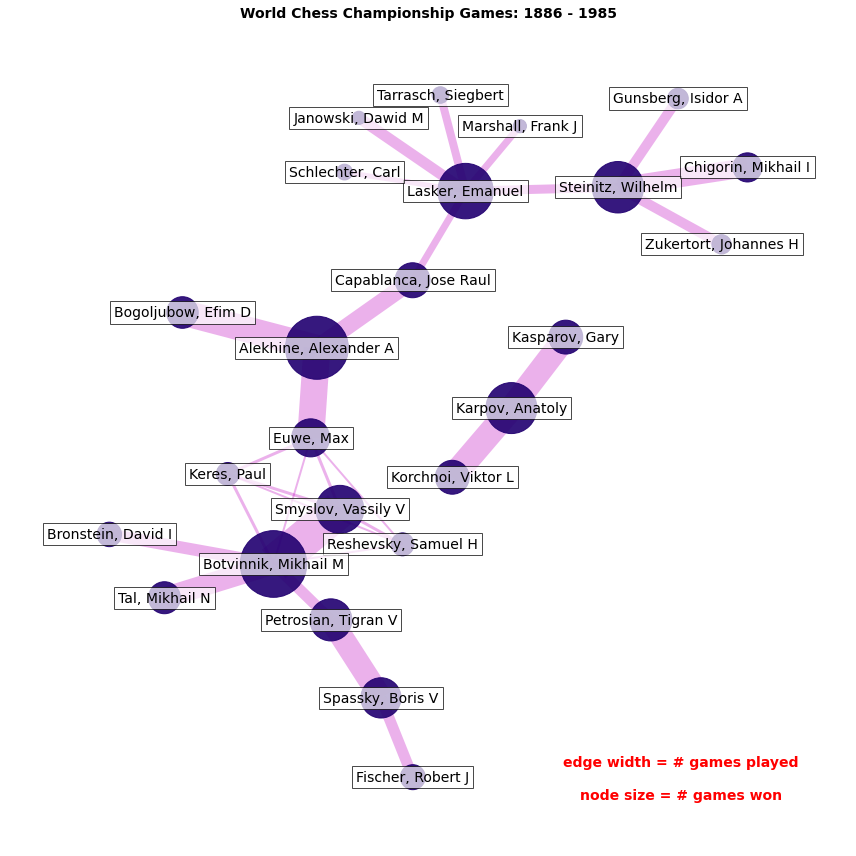

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# tag names specifying what game info should be
# stored in the dict on each digraph edge
game_details = ["Event", "Date", "Result", "ECO", "Site"]


def chess_pgn_graph(pgn_file="chess_masters_WCC.pgn.bz2"):
    """Read chess games in pgn format in pgn_file.

    Filenames ending in .bz2 will be uncompressed.

    Return the MultiDiGraph of players connected by a chess game.
    Edges contain game data in a dict.

    """
    import bz2

    G = nx.MultiDiGraph()
    game = {}
    with bz2.BZ2File(pgn_file) as datafile:
        lines = [line.decode().rstrip("\r\n") for line in datafile]
    for line in lines:
        if line.startswith("["):
            tag, value = line[1:-1].split(" ", 1)
            game[str(tag)] = value.strip('"')
        else:
            # empty line after tag set indicates
            # we finished reading game info
            if game:
                white = game.pop("White")
                black = game.pop("Black")
                G.add_edge(white, black, **game)
                game = {}
    return G


G = chess_pgn_graph()

print(
    f"Loaded {G.number_of_edges()} chess games between {G.number_of_nodes()} players\n"
)

# identify connected components of the undirected version
H = G.to_undirected()
Gcc = [H.subgraph(c) for c in nx.connected_components(H)]
if len(Gcc) > 1:
    print(f"Note the disconnected component consisting of:\n{Gcc[1].nodes()}")

# find all games with B97 opening (as described in ECO)
openings = {game_info["ECO"] for (white, black, game_info) in G.edges(data=True)}
print(f"\nFrom a total of {len(openings)} different openings,")
print("the following games used the Sicilian opening")
print('with the Najdorff 7...Qb6 "Poisoned Pawn" variation.\n')

for (white, black, game_info) in G.edges(data=True):
    if game_info["ECO"] == "B97":
        summary = f"{white} vs {black}\n"
        for k, v in game_info.items():
            summary += f"   {k}: {v}\n"
        summary += "\n"
        print(summary)

# make new undirected graph H without multi-edges
H = nx.Graph(G)

# edge width is proportional number of games played
edgewidth = [len(G.get_edge_data(u, v)) for u, v in H.edges()]

# node size is proportional to number of games won
wins = dict.fromkeys(G.nodes(), 0.0)
for (u, v, d) in G.edges(data=True):
    r = d["Result"].split("-")
    if r[0] == "1":
        wins[u] += 1.0
    elif r[0] == "1/2":
        wins[u] += 0.5
        wins[v] += 0.5
    else:
        wins[v] += 1.0
nodesize = [wins[v] * 50 for v in H]

# Generate layout for visualization
pos = nx.kamada_kawai_layout(H)
# Manual tweaking to limit node label overlap in the visualization
pos["Reshevsky, Samuel H"] += (0.05, -0.10)
pos["Botvinnik, Mikhail M"] += (0.03, -0.06)
pos["Smyslov, Vassily V"] += (0.05, -0.03)

fig, ax = plt.subplots(figsize=(12, 12))
# Visualize graph components
nx.draw_networkx_edges(H, pos, alpha=0.3, width=edgewidth, edge_color="m")
nx.draw_networkx_nodes(H, pos, node_size=nodesize, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(H, pos, font_size=14, bbox=label_options)

# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("World Chess Championship Games: 1886 - 1985", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "edge width = # games played",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = # games won",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()